# Overview of Repository State and Experiment Findings

Duncan Mazza | June 2022

In [41]:
from map_processing.data_models import *
import matplotlib.pyplot as plt
from map_processing.graph_generator import GraphGenerator
from map_processing import ASSUMED_TAG_SIZE, GT_TAG_DATASETS
from run_scripts.validate_analogous_params import validate_analogous_params
from map_processing.cache_manager import MapInfo
from map_processing.sweep import sweep_params
import matplotlib as mpl

mpl.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = [10, 5]
NUM_PROCESSES = 10  # For multi-processed parameter sweep

## Introduction

My recent work with the invisible-map-generation project has been concentrated on the following five areas:

1. Changes to the data flow (namely, via the adoption of pydantic models) and organization of the code base.
2. Creating a data set simulation module that allows for enhanced experimentation capabilities and high-level validation of the `map_processing` package.
5. Testing a different way of computing the odometry nodes' information matrices.
3. Using parameter sweeping of both data set generation parameters and optimization parameters to test expectations about the behavior of the optimizations.
4. Using parameter sweeping of optimization parameters to test hypothesis about a chi2-based log-normalized metric being a suitable alias for the ground truth metric.

The following sections elaborate on this work, with the goal being to provide the reader an understanding of the code base including both how and why things work and the reasons behind design decisions, as well as an understanding of my findings from running various experiments.

<br>

## Data Flow and Organizational Improvements

### pydantic Models

As mentioned in the introduction, I made the decision to adopt [pydantic](https://pydantic-docs.helpmanual.io/). All pydantic models (by which I mean classes that derive from `pydantic.BaseModel`) can be found in [data_models.py](../map_processing/data_models.py) in the code base The two primary pydantic features advantageous to this project are...

1. Data validation: instances of classes derived from pydantic models can only be constructed if the provided data match the specified types of the attributes.
2. Serialization: instances of classes derived from pydantic models can be easily serialized and deserialized to/from JSON.

A clear use case for pydantic models is in the deserialization of raw unprocessed data sets uploaded by InvisibleMap and in the serialization of optimized data sets; the pydantic models used for these two scenarios are `UGDataSet` ("unprocessed graph data set") and `PGDataSet` ("processed graph data set"). The `UGDataSet` model exemplifies another related design decision I made: the use of class properties wherever possible. For example, the class method that constructs a `Graph` object, `Graph.as_graph`, assembles the graph data structure from a `UGDataSet` instance by accessing its various properties, such as `poses_by_pose_ids` which maps pose IDs to their respective $\text{SE}(3)$ vectors.

Another use case for pydantic models is in the recording of experimental data. When running experiments, it can be advantageous to serialize the results along with the parameters of the experiments in such a manner that the results can be quickly deserialized. By encapsulating all the parameters for optimization and data set generation in pydantic models along with all the resultant data in pydantic models, any relevant information to an experiment can be easily serialized and deserialized for later reference. (This also enables traceability with generated data sets because the data set generation parameters are appended to the JSON of the generated data set.) As an example, consider the deserialization of serialized `OSweepResults` object, which can be generated by running [optimize_graphs_and_manage_cache.py](../run_scripts/optimize_graphs_and_manage_cache.py) with the `-s` flag:

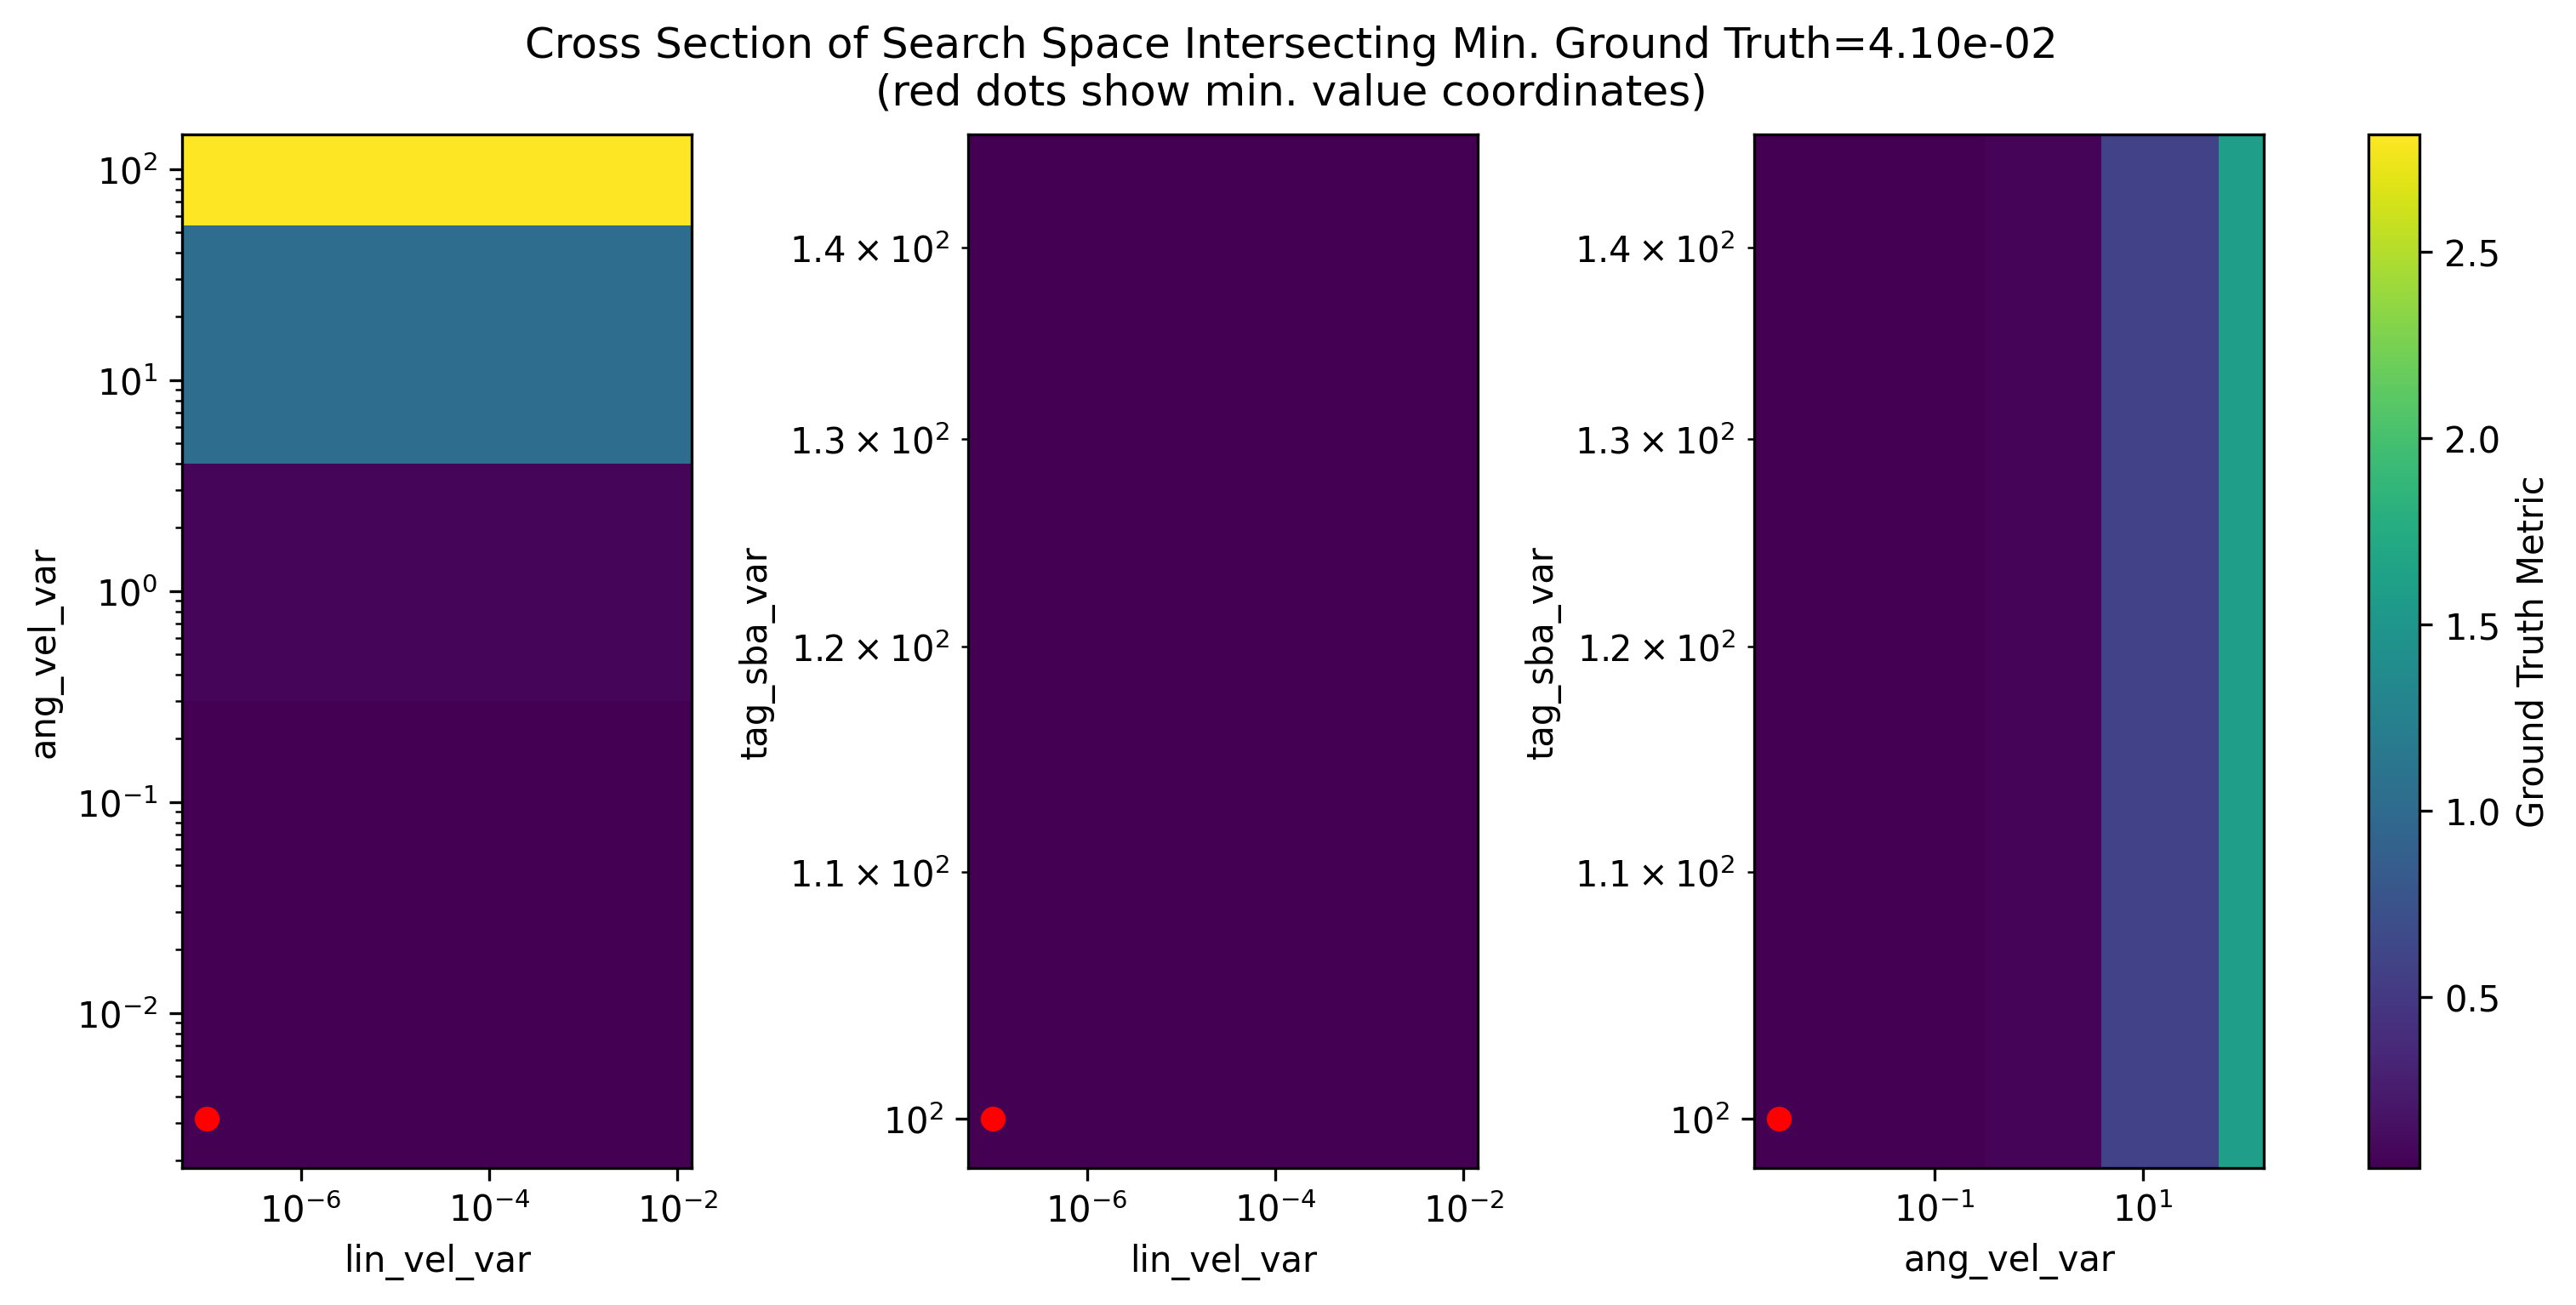

In [48]:
# This result was generated using experimental code - do not try to
# derive conclusions from this plot.
with open("supporting_files/osweepresults_example.json", "r") as f:
    s = f.read()
osr: OSweepResults = OSweepResults.parse_raw(s)
fig: plt.Figure = osr.visualize_results_heatmap()
plt.show()

A major change that was made was the adoption of pydantic models for storing the configuration of an optimization: all the high-level functions for optimization are parameterized only via instances of the `OConfig` pydantic model. One of the ways in which this became useful was in recording the optimization parameters used during a parameter sweep; the aforementioned `OSweepResults` pydantic model, for example, has an attribute whose type is `OConfig`.

> *Aside about numpy arrays in pydantic models:* Because `ndarray`s are not one of the data types natively supported by pydantic, some hoops need to be jumped through to make a pydantic model's field of a `ndarray` type. The `OG2oOptimizer` class provides an example of how this is done. With hindsight, I recommend that lists be used as the underlying data type for array-like data and for the array data structure to be accessed via a property. The `gt_results_arr` property of the `OSweepResults` class provides a good example of this.

### Repository Organization

Over time, I have added new features to and changed the organization of the repository. Rather than provide a list of the changes I have made, I provide a description of every important element to this code base.

- [map_processing](../map_processing) package: Contains all optimization and data set generation-related modules.
    - [cache_manager.py](../map_processing/cache_manager.py): Code for managing the `.cache` directory, which includes storing experiment results, ground truth data, unprocessed map data, and caching of processed map data.
    - [data_models.py](../map_processing/data_models.py): Contains all the pydantic models.
    - [graph.py](../map_processing/graph.py): Contains the `Graph` class, which is the intermediate data structure between an unprocessed data set and a `g2o` sparse optimizer object.
    - [graph_generator.py](../map_processing/graph_generator.py): Contains the `GraphGenerator` class, which is used to generate synthetic data sets.
    - [graph_opt_hl_interface.py](../map_processing/graph_opt_hl_interface.py): Provides a set of functions that serve as a high-level abstraction of the optimization capabilities.
    - [graph_opt_plot_utils.py](../map_processing/graph_opt_plot_utils.py): matplotlib-based plotting utilities used for visualizing optimization results.
    - [graph_opt_utils.py](../map_processing/graph_opt_utils.py): Utility functions useful for optimization.
    - [graph_util_get_neighbors](../map_processing/graph_util_get_neighbors.py): Utility functions for neighbor-finding within graphs.
    - [graph_vertex_edge_classes.py](../map_processing/graph_vertex_edge_classes.py): Contains the `Vertex` and `Edge` classes.
    - [sweep.py](../map_processing/sweep.py): Contains the `sweep` function useful for parameter sweeping.
    - [transform_utils.py](../map_processing/transform_utils.py): Contains utility functions for wrangling $\text{SE}(3)$ and $\text{SO}(3)$ data types.
- [run_scripts](../run_scripts) folder: Contains all scripts that make use of the `map_processing` package.
    - [generate_datasets.py](../run_scripts/generate_datasets.py): CLI that enables the generation of synthetic data sets.
    - [optimize_graphs_and_manage_cache](../run_scripts/optimize_graphs_and_manage_cache.py) (formerly, `graph_manager_user.py`): CLI that enables optimization of cached and synthetic data sets (along with optimization parameter sweeps), as well as the caching and uploading of data from/to the Firebase database.
    - [process_graphs.py](../run_scripts/optimize_graphs_and_manage_cache.py): An indefinitely running script that listens for changes to the Firebase database and optimizes any newly uploaded graphs.
    - [validate_analogous_params.py](../run_scripts/validate_analogous_params.py): A script that runs a data set generation and optimization parameter sweep with the purpose of understanding the relationship between parameters that are analogous to each other on the sides of data set generation and optimization.
    - [validate_pseudo_gt_metric.py](../run_scripts/validate_pseudo_gt_metric.py): A script that generates a data set and runs a parameter sweep with the purpose of understanding the relationship between various proxies to the ground truth metric and the ground truth metric itself, including raw $\Chi^2$, the log-normalized metric (referred to as $\alpha$), and both of the aforementioned in the context of the subgraph comparison routine. Information on the subgraph comparison routine can be found in [graph_opt_hl_interface.py](../map_processing/graph_opt_hl_interface.py).
- [.cache](../.cache) folder: Where all data sets (unprocessed, processed, and ground truth) and experiment results are cached.
    - [directory.json](../.cache/directory.json): A mapping managed by the `GraphManagerSingleton` class which is only particularly useful in the context of associating file names with the name by which they are referenced in Firebase, but is also used for consistency with all unprocessed data sets (even if synthetic).
    - [generated](../.cache/generated) folder: The folder in which generated data sets are cached by the [generate_datasets.py](../run_scripts/generate_datasets.py) CLI.
    - [ground_truth](../.cache/ground_truth) folder: The folder in which ground truth data sets are cached.
        - [ground_truth_mapping.json](../.cache/ground_truth/ground_truth_mapping.json): Maps ground truth data sets to the unprocessed maps with which they are associated.
    - [pgt_validation_results](../.cache/pgt_validation_results) folder: The folder in which experiment results from the [validate_pseudo_gt_metric.py](../run_scripts/validate_pseudo_gt_metric.py) script are stored.
    - [sweep_results](../.cache/sweep_results) folder: The folder in which parameter sweep results (from running [optimize_graphs_and_manage_cache](../run_scripts/optimize_graphs_and_manage_cache.py) with the `-s` flag) are stored.
    - [TestProcessed](../.cache/TestProcessed) folder: The folder in which processed data sets are cached.
    - [unprocessed_maps](../.cache/unprocessed_maps) folder: The folder in which unprocessed maps from Firebase are cached.
- [archive](../archive) folder: Where code (including documentation and Jupyter notebooks) is put when it is no longer actively used, and/or the code has not yet been updated to be compatible with changes made elsewhere in the codebase, and/or a new implementation of its capabilities is added (as in the case of parameter sweeping).
- [tests](../tests) folder: Where the unit tests live.
    - *Note: there are currently only a couple unit tests that were implemented to address specific issues with pydantic model validation and deserialization; many more unit tests could be added.*

<br>

## Data Set Simulation

The data set simulation works by iterating through a given sequence of poses and simulating tag observations at each pose. Gaussian noise can optionally be introduced into both the odometry path and the simulated observation. For a tag to be visible from a given odometry pose, it must meet three criteria:

1. Distance to the tag is under the given threshold.
2. Angle-of-attack to the tag is under the given threshold.
3. Pixel coordinates of the tag fit entirely within the sensor.

Simulated data sets are either derived from a parametric path or from a real data set. In the case of a parametric path that specifies the position of the simulated phone as a function of time, a hard-coded set of tag poses must be provided, and the phone orientation is obtained via a (rotated) Frenet frame computed using a discrete derivative of the path. In the other case, the odometry and tag poses are acquired from some existing unprocessed map data set; to arbitrate between disagreeing estimates of tag poses in the global reference frame, the simulator ascribes to each tag the pose in the global reference frame from whatever odometry pose first observed it.

 To illustrate the effect of the noise parameters, consider a simple elliptical path is used that makes a loop in front of three tags in a line:

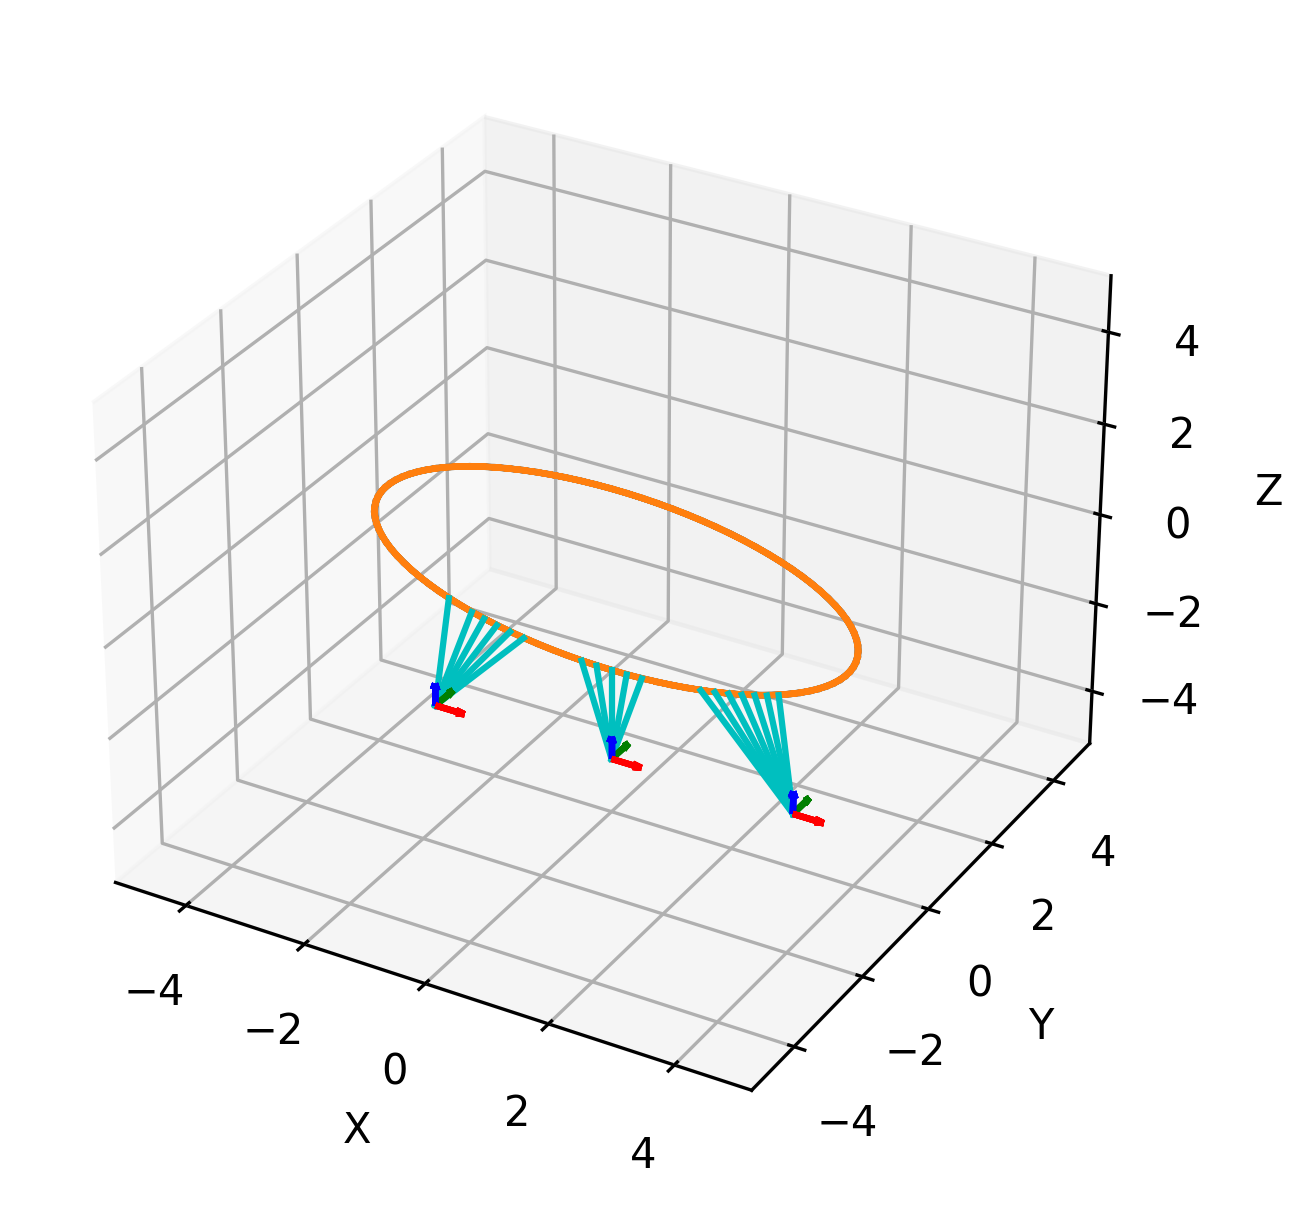

In [45]:
# This data set name corresponds to a hard-coded set of tag poses from the map_processing module.
tag_data_set = "3line"

# These parameters specify an 8 x 4 elliptical path coplanar with the X-Z plane centered at (0, 0, 0);
# because one loop is completed in t=2pi seconds, the t_max parameter of 6pi specifies an elliptical path
# that loops around 3 times.
path_args = {'e_cp': (0.0, 0.0), 'e_xw': 8.0, 'e_zw': 4.0, 'xzp': 0.0}
gen_params = GenerateParams(dataset_name=tag_data_set, parameterized_path_args=path_args, t_max=6 * np.pi,
                            n_poses=100, tag_size=ASSUMED_TAG_SIZE)

gg = GraphGenerator(path_from=GraphGenerator.PARAMETERIZED_PATH_ALIAS_TO_CALLABLE["e"], gen_params=gen_params,
                    tag_poses_for_parameterized=GT_TAG_DATASETS[tag_data_set])

# The data set generation occurs upon construction of a GraphGenerator object; now let's visualize it:
gg.visualize()

The RGB reference frames are the tag observations, and the teal lines denote the translation between the odometry node that observed a tag and the tag.

Now, consider the addition of noise to the odometry path. Note that the translational noise parameters, $\mathbf{\sigma}^2_v \in \mathbb{R}^3$ for odometry specify the variance of the velocity in each direction. Therefore, the translational noise vector, $\mathbf{t}$, that is added to each odometry-to-odometry node transform can be described as $\mathbf{t} \sim \mathcal{N}(0,\, \Delta t^2\mathbf{\sigma}^2_v) \in \mathbb{R}^3$ where $\Delta t$ is the time difference between the odometry poses. Rotational noise, on the other hand, is parameterized by way of the variance of the angle of a rotation about the vertical axis of the odometry pose.

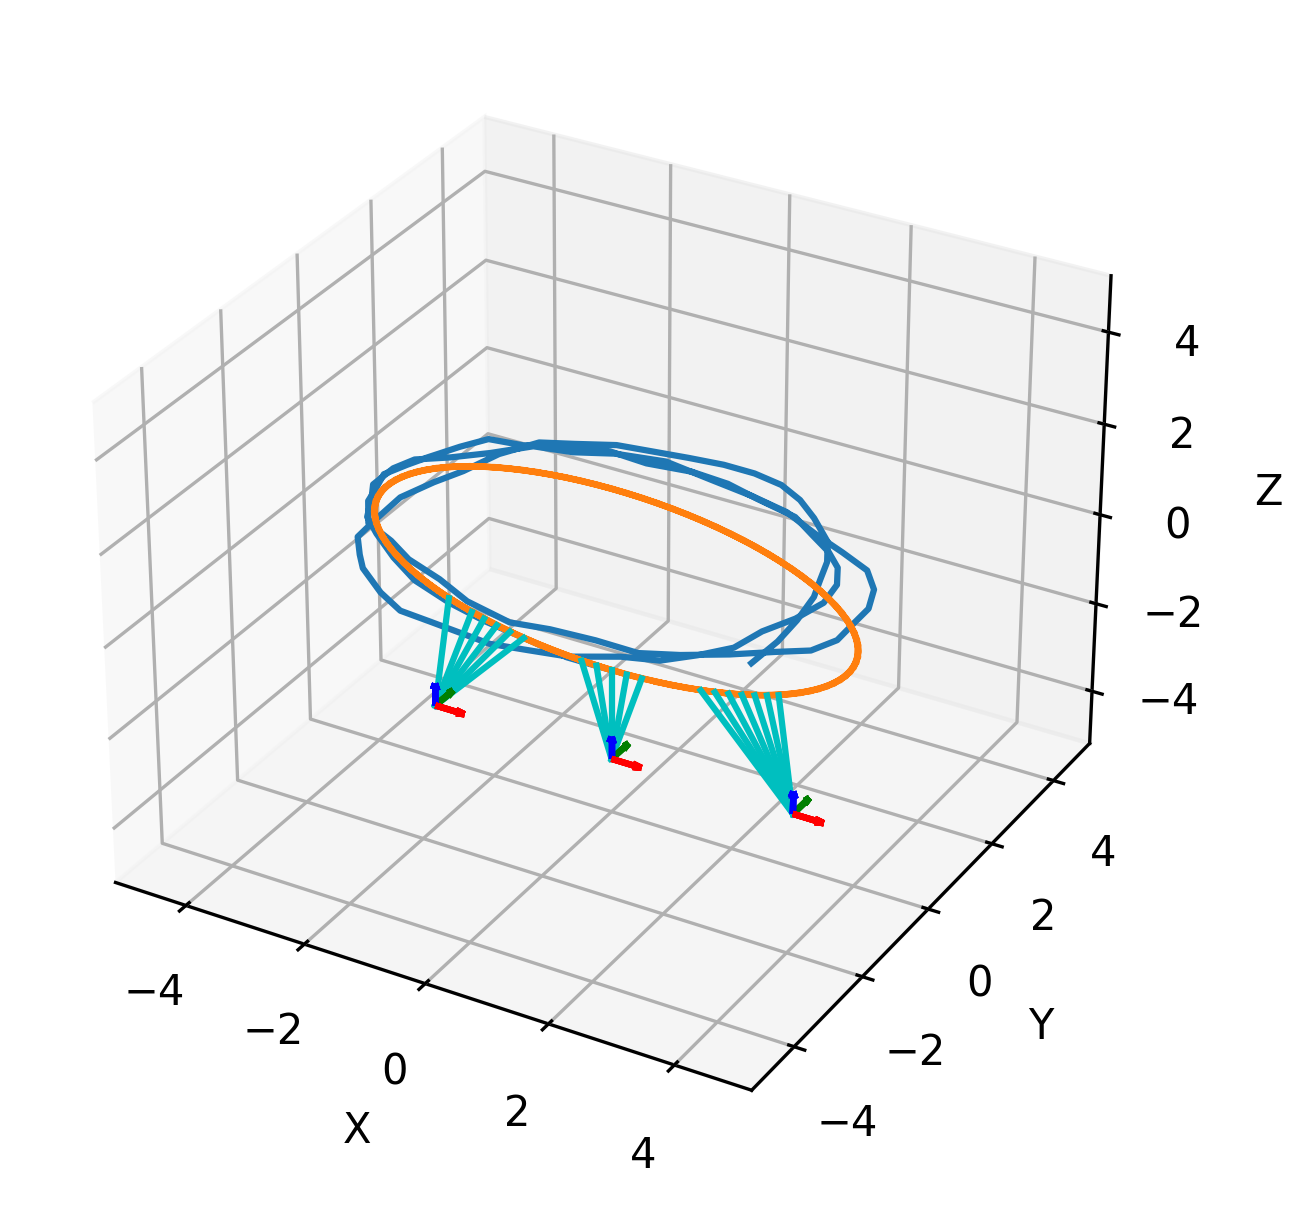

In [44]:
gen_params_n1 = gen_params.copy(deep=True)
gen_params_n1.odometry_noise_var = {
    GenerateParams.OdomNoiseDims.X:     0.1,
    GenerateParams.OdomNoiseDims.Y:     0.1,
    GenerateParams.OdomNoiseDims.Z:     0.1,
    GenerateParams.OdomNoiseDims.RVERT: 0.05,
}
gg_n1 = GraphGenerator(path_from=GraphGenerator.PARAMETERIZED_PATH_ALIAS_TO_CALLABLE["e"], gen_params=gen_params_n1,
                    tag_poses_for_parameterized=GT_TAG_DATASETS[tag_data_set])
gg_n1.visualize()

The teal path - which represents the noisy path - shows how the translational and rotational noise accumulate in a significant deviation from the original path (in orange). The observation vectors remain unchanged, however, because observations are made with respect to the original noiseless path.

By contrast, if nonzero observation noise is prescribed without any odometry noise, the tag poses will disagree, but the odometry path will be noiseless. Odometry noise is applied in pixel space; i.e., the camera intrinsics are used to compute pixel coordinates for each tag corner, gaussian noise is applied to the pixel coordinates, then the tag pose is re-computed.

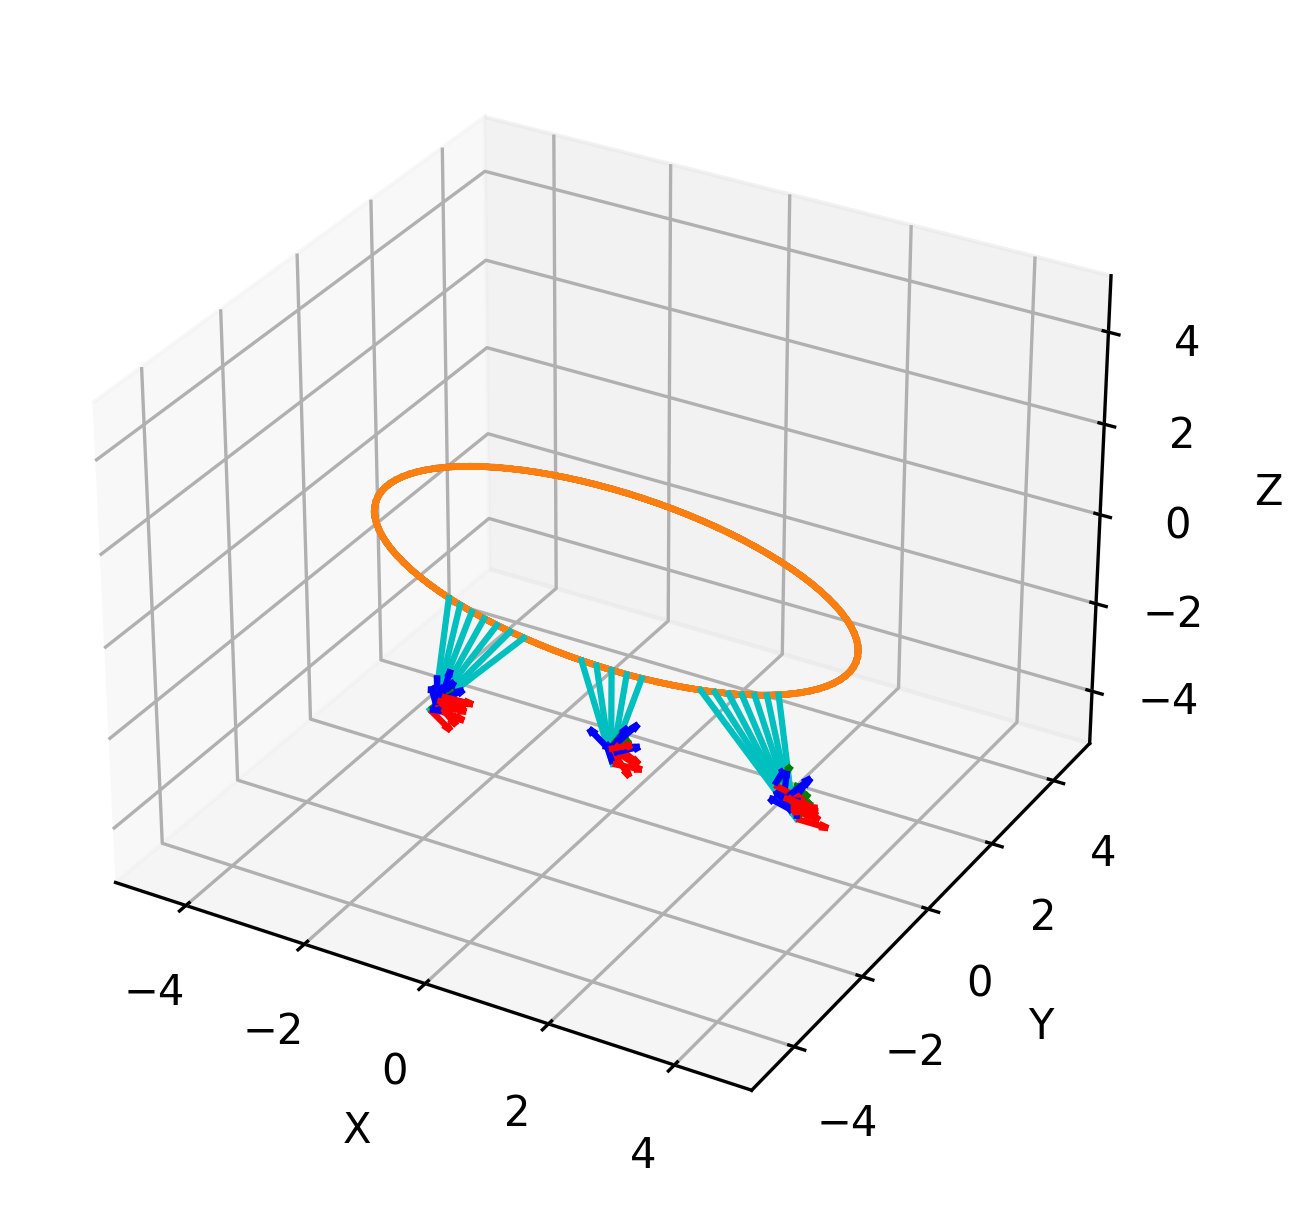

In [43]:
gen_params_n2 = gen_params.copy(deep=True)
gen_params_n2.obs_noise_var = 10
gg_n2 = GraphGenerator(path_from=GraphGenerator.PARAMETERIZED_PATH_ALIAS_TO_CALLABLE["e"], gen_params=gen_params_n2,
                    tag_poses_for_parameterized=GT_TAG_DATASETS[tag_data_set])
gg_n2.visualize()

## Relationship Between Analogous Parameters

Because the data set generation allows us to fine-tune the noise introduced into a data set, we can batch-generate data sets with a variety of noise parameters to understand how the optimization works with varying levels of odometry and observation error. The noise models used in data set generation reflect similar assumptions that are made for the information matrix computation; specifically, the odometry-to-odometry and odometry-to-SBA node edges' information matrices. While the latter are simply computed as the inverse of the diagonal matrix constructed from x- and y-axis variance values (in pixel space), the former are computed in a more complex manner.

### Odometry Rotation Information Matrix Computation

Let $x_i$ and $x_j$ denote two nodes separated in time by $\Delta t_{ij}$ and in space by the transform $T_{ij} \in \text{SE}(3)$ composed of a translation component $\mathbf{t}_{ij} \in \mathbb{R}^3$ and a rotation component $\mathbf{R} \in \text{SO}(3)$. It is assumed that the translation component of the error vector vector, $\mathbf{e}_{t_{ij}} \in \mathbb{R}^3$, is distributed as follows: $\mathbf{e}_t \sim \mathcal{N}(0,\, \Delta t^2\mathbf{\sigma}^2_v)$. As for the rotation error vector (which is the vector difference between the compact quaternion equivalent of $\mathbf{R}$), $\mathbf{e}_{q_{ij}} \in \mathbb{R}^3$, rather than considering probability distributions over the $\text{SE}(3)$ manifold, a simplification is made equivalent to that which is made during data set generation: the rotation noise is assumed to be modeled by a rotation of some angle about the gravity axis, where the variance of the angle of rotation's Gaussian distribution is given by $\Delta t^2 \sigma_\omega^2$.

However, because quaternion vectors' elements are not linearly proportional to the angle of rotation about some axis, some further approximations are in order. Consider the optimal information matrix for the rotation component of the error:

$$
\mathbf{\Lambda}_R \triangleq \left[\begin{matrix}
    \sigma_{q_{x}}^2 & 0 & 0 \\
    0 & \sigma_{q_{y}}^2 & 0 \\
    0 & 0 & \sigma_{q_{z}}^2 \\
\end{matrix}\right]^{-1}
$$

where $\sigma_{q_{x}}^2$, $\sigma_{q_{x}}^2$, and $\sigma_{q_{x}}^2$ are the variances of the error compact quaternion's x, y, and z elements. Because we are only concerned with unit quaternions, the compact quaternions are of the form:

$$
\mathbf{q} = \left[ \begin{matrix}
    w_x sin(\theta / 2) & w_y sin(\theta / 2) & w_z sin(\theta / 2)
\end{matrix}\right]^\top
$$

Because we assume that $\theta \sim \mathcal{N}(0,\, \Delta t^2\sigma^2_\omega)$, a Taylor series approximation can be used to derive a distribution for a linearized $sin(\theta / 2)$:

$$
sin(\theta / 2) \sim \mathcal{N}\left(sin(\theta / 2),\, \left( \frac{\Delta t \sigma_\omega \cos(\mu_\theta)}{2} \right)^2 \right)
$$

Therefore, assuming $\mu_\theta = 0$ and sufficiently small $\theta$, the distribution of $\mathbf{q}$ can be approximated as:

$$
\mathbf{q} \sim \mathcal{N}\left(0, \frac{|\mathbf{w}| \Delta t \sigma_\omega^2}{4}\right)
$$

(Note that $|\mathbf{w}|$ here denotes the absolute value of the axis' vector's elements, not the norm of the axis vector.) However, because the reciprocals of the variances are needed when computing $\mathbf{\Lambda}_R$, any rotation axis that is also a basis vector (i.e., has components = 0), then a divide-by-zero error will occur. If our assumption that the rotation error occurs around a perfectly measured gravity axis was reality, then we would in fact want to assign infinite information to that element of the quaternion vector. However, because that is not the case, to avoid adverse effects from weighting any single element of the rotation error vector too much, an arbitrarily-defined lower limit is imposed on the elements of the $\mathbf{w}$ vector.

### Optimization Parameter Sweeping

One way the efficacy of the above approach can be explored is through generating a data set and comparing the noise variance parameters used for generation with the noise parameters used for optimization. Below is an example that uses a generated data set derived from a real data set.

In [49]:
# Generate a derived data set
data_set_name = "example_data_set_qea_room"
with open(f"supporting_files/{data_set_name}.json", "r") as f:
    data_set_str = f.read()
ug_data_set = UGDataSet.parse_raw(data_set_str)
gen_params_sweep = GenerateParams(
    dataset_name=data_set_name, tag_size=ASSUMED_TAG_SIZE, obs_noise_var=0.5,
    odometry_noise_var = {
        GenerateParams.OdomNoiseDims.X:     0.0001,
        GenerateParams.OdomNoiseDims.Y:     0.00001,
        GenerateParams.OdomNoiseDims.Z:     0.0001,
        GenerateParams.OdomNoiseDims.RVERT: 0.00001,
    }
)
gg_sweep = GraphGenerator(path_from=ug_data_set, gen_params=gen_params_sweep)
gen_data_set, gt_gen_data_set = gg_sweep.export()
map_info = MapInfo(map_json_name=data_set_name, map_name=data_set_name, map_dct=gen_data_set.dict())

# Instantiate the configuration for the parameter sweeping
compute_inf_params = OComputeInfParams()
sweep_config = {
    # OConfig.OConfigEnum.ODOM_TAG_RATIO: (np.linspace, [1, 1, 1]),
    OConfig.OConfigEnum.LIN_VEL_VAR: (np.geomspace, [1e-6, 1e-2, 10]),
    OConfig.OConfigEnum.ANG_VEL_VAR: (np.geomspace, [1e-6, 1e-2, 10]),
    OConfig.OConfigEnum.TAG_SBA_VAR: (np.geomspace, [1e-2, 1e+1, 10]),
    # OConfig.OConfigEnum.GRAV_MAG: (np.linspace, [1, 1, 1]),
}

Generating list of optimization sweeping parameters...
1000 parameters generated for sweeping
Starting multi-process optimization parameter sweep (with 10 processes)...
Completed sweep (parameter idx=51)
Completed sweep (parameter idx=26)
Completed sweep (parameter idx=1)
Completed sweep (parameter idx=101)
Completed sweep (parameter idx=126)
Completed sweep (parameter idx=176)
Completed sweep (parameter idx=76)
Completed sweep (parameter idx=151)
Completed sweep (parameter idx=226)
Completed sweep (parameter idx=201)
Completed sweep (parameter idx=52)
Completed sweep (parameter idx=127)
Completed sweep (parameter idx=77)
Completed sweep (parameter idx=27)
Completed sweep (parameter idx=177)
Completed sweep (parameter idx=2)
Completed sweep (parameter idx=102)
Completed sweep (parameter idx=152)
Completed sweep (parameter idx=227)
Completed sweep (parameter idx=202)
Completed sweep (parameter idx=53)
Completed sweep (parameter idx=128)
Completed sweep (parameter idx=78)
Completed sweep

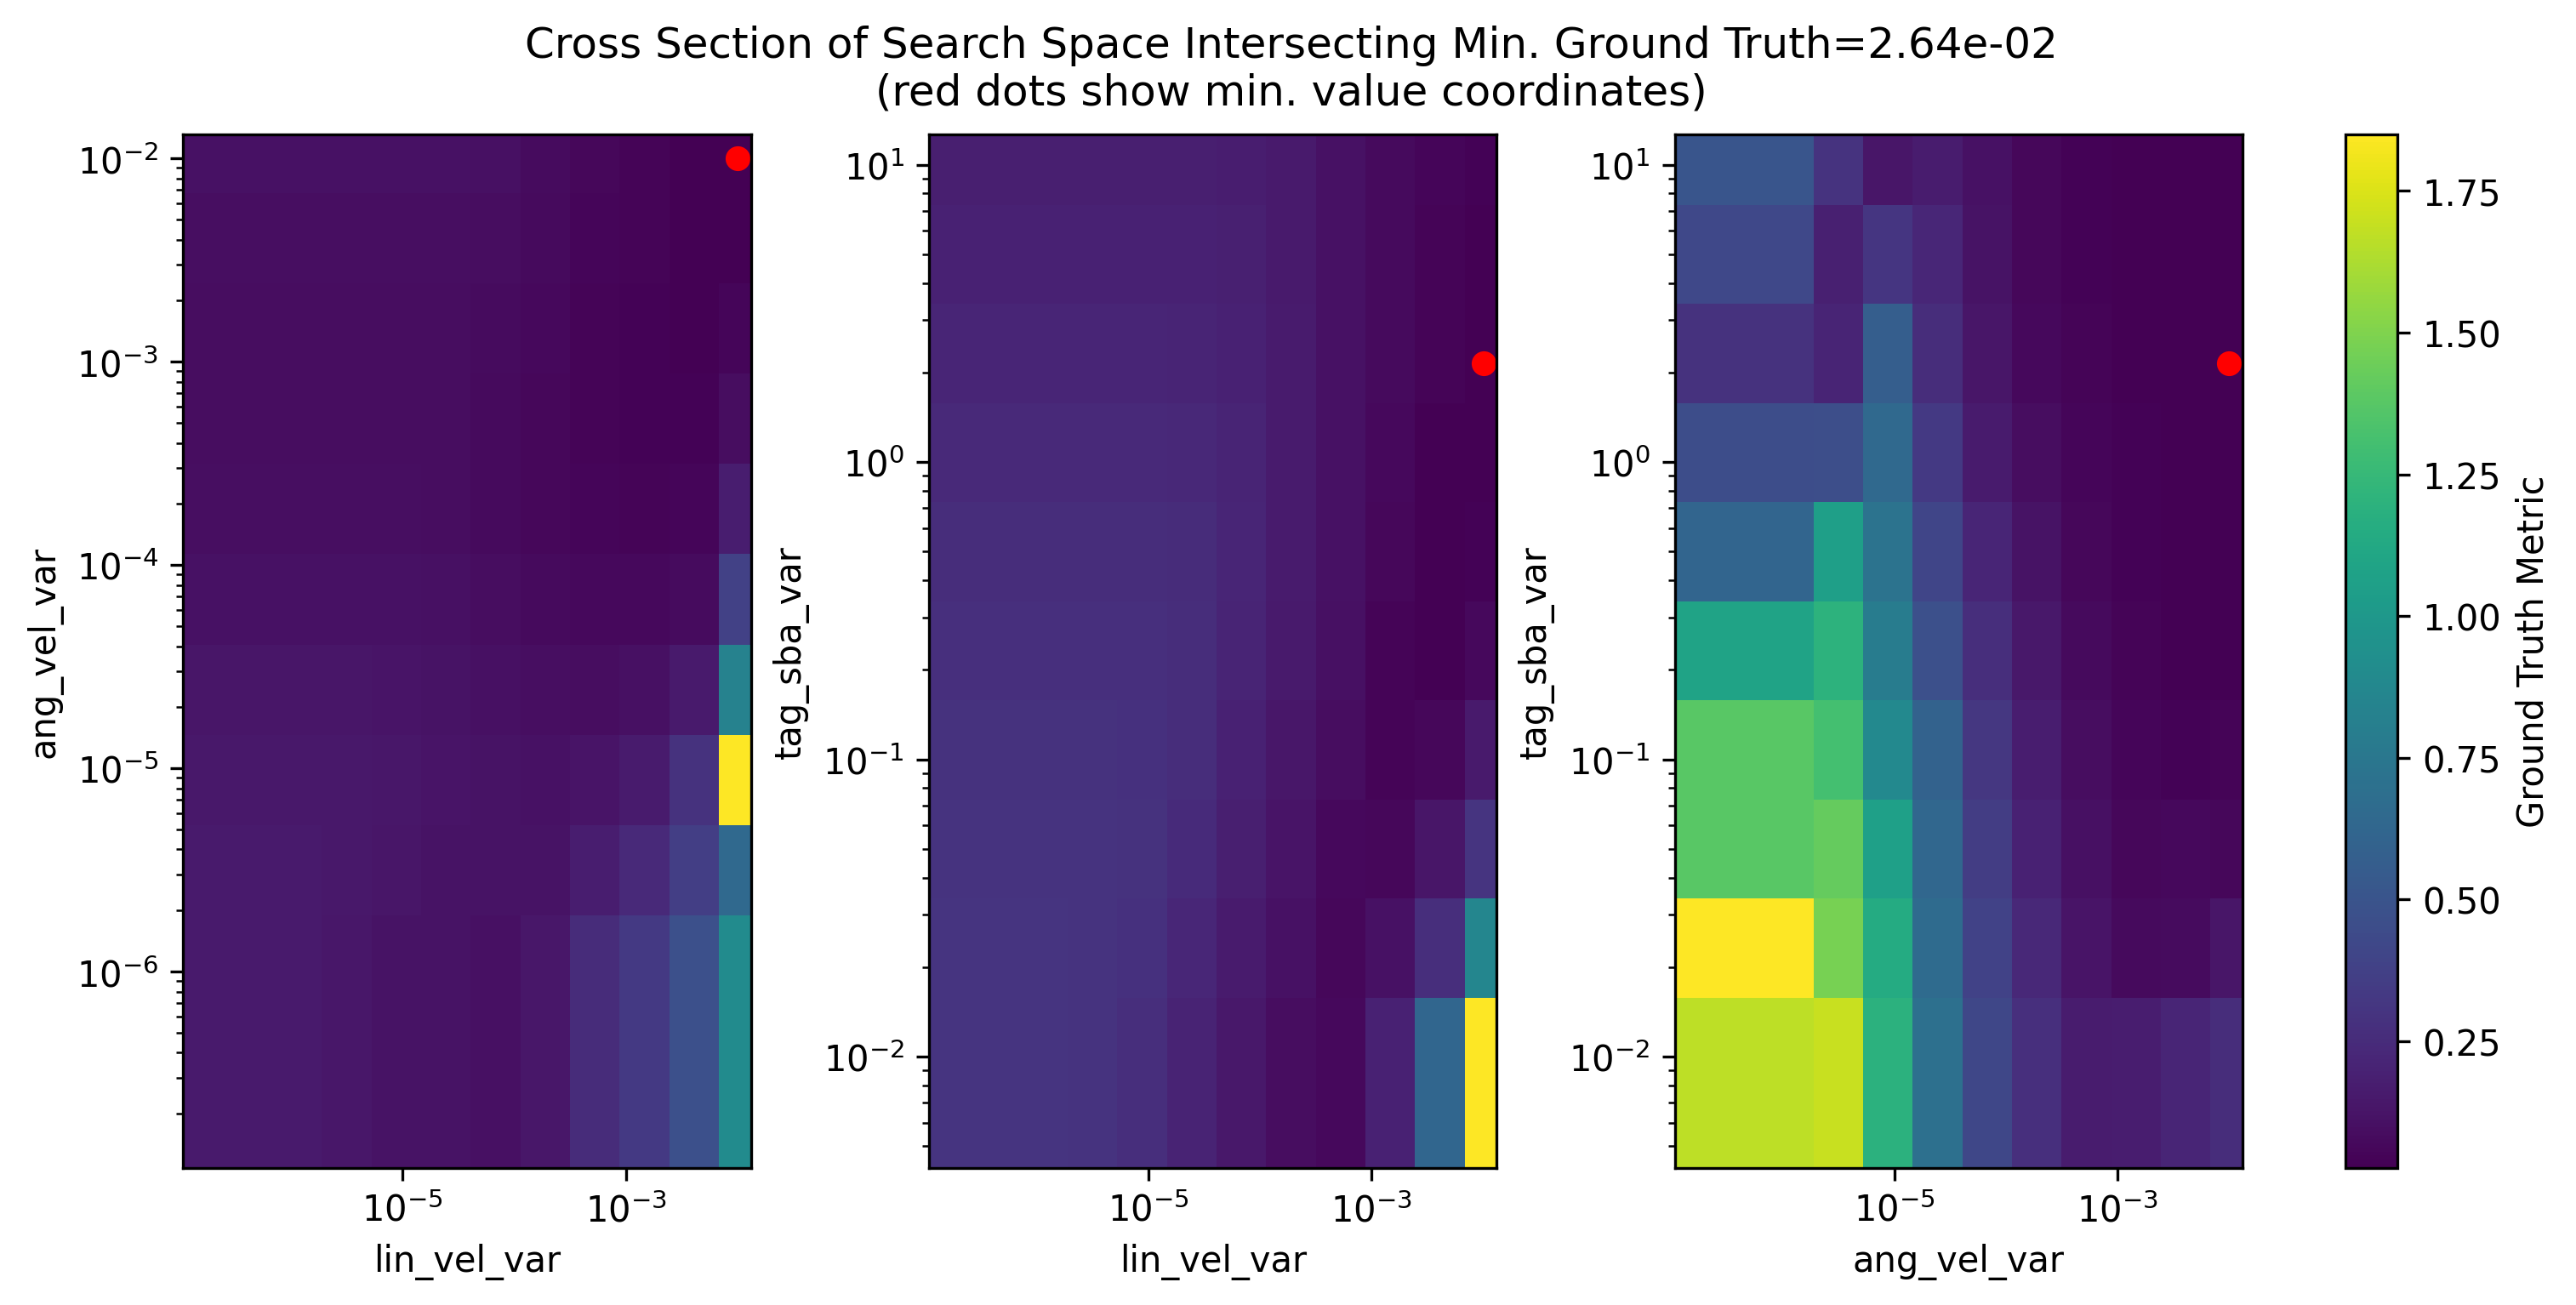

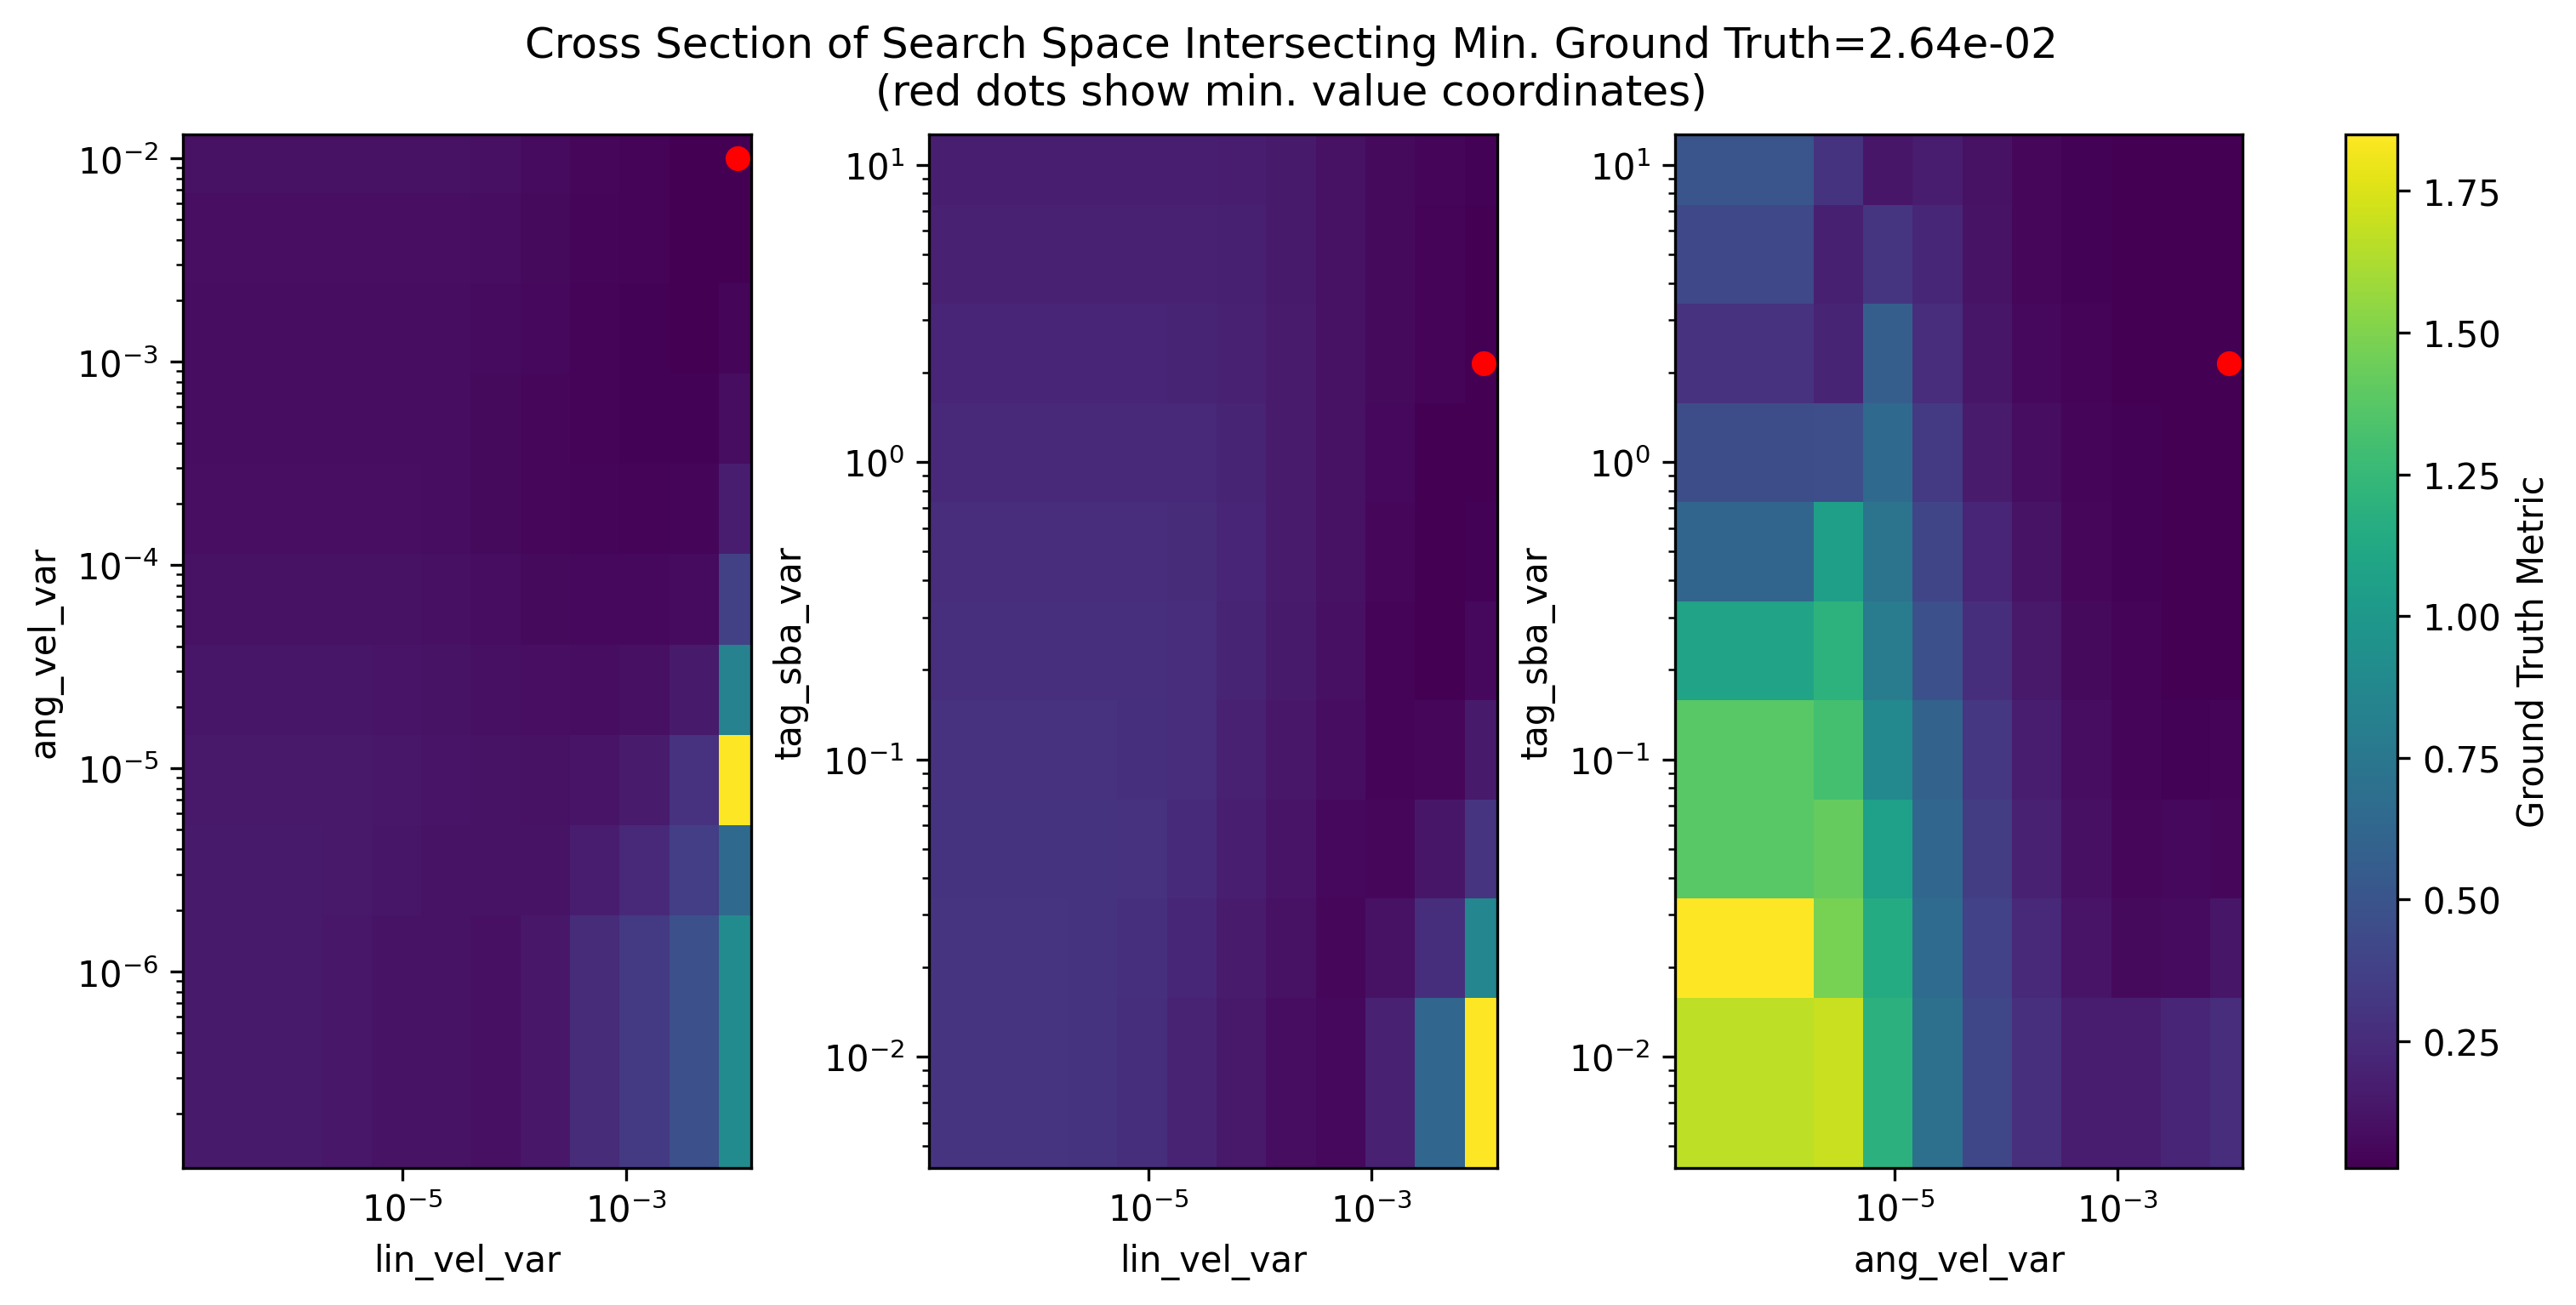

In [50]:
# Run the parameter sweeping
osr = sweep_params(mi=map_info, ground_truth_data=gt_gen_data_set.as_dict_of_se3_arrays,
             base_oconfig=OConfig(is_sba=True, compute_inf_params=compute_inf_params),
             sweep_config=sweep_config, ordered_sweep_config_keys=[key for key in sweep_config.keys()],
             verbose=True, generate_plot=False, show_plot=False, num_processes=NUM_PROCESSES)
osr.visualize_results_heatmap()



### Joint Optimization and Data Set Generation Parameter Sweeping

## Relationship Between the Ground Truth Metric and its Proxies

TODO
